# Newsgroups

In order to practice and learn to work with text data, let's use the 20 Newsgroups archive.

Things we're going to do:
- get the data
- work with some feature extraction
- develop a model that can classify the Newsgroups

In [16]:
## import essentials and anticipated packages

import numpy as np
import pandas as pd
import re

from sklearn.datasets import fetch_20newsgroups

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer, CountVectorizer


from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
#%matplotlib notebook

In [17]:
train = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'),subset='train')
test = fetch_20newsgroups(remove=('headers', 'footers', 'quotes'),subset='test')

In [18]:
## What's the distribution like?

## check that I know how the data is structured.
print(train.data[7][:100]) ##this is such a newsgroup discussion about comptuers


## set as Pandas objects for easier access and manipulation
y_train = pd.Series(train.target)
y_test = pd.Series(test.target) 
X_train = pd.DataFrame(train.data)
X_test = pd.DataFrame(test.data)

## check skew in data
print(y_train.value_counts())
print(y_train.value_counts()/y_train.value_counts().mean())#not particularly skew


##A dictionary of the topics for ease of reference.
train.target_names
target_names_dict = { i : train.target_names[i] for i in range(0,20)}

                                                                      
ALL this shows is that YOU do
10    600
15    599
8     598
9     597
11    595
13    594
7     594
14    593
5     593
12    591
2     591
3     590
6     585
1     584
4     578
17    564
16    546
0     480
18    465
19    377
dtype: int64
10    1.060633
15    1.058865
8     1.057097
9     1.055330
11    1.051794
13    1.050027
7     1.050027
14    1.048259
5     1.048259
12    1.044723
2     1.044723
3     1.042956
6     1.034117
1     1.032349
4     1.021743
17    0.996995
16    0.965176
0     0.848506
18    0.821990
19    0.666431
dtype: float64


In [19]:

## Let's make the length of the message a feature.

for df in (X_train, X_test):
    df.rename({0:'text'}, axis=1, inplace=True)
    df['text length'] = df['text'].apply(lambda x: len(x))


In [20]:
## I would love to count all the numeric expressions in the document. Science and sports probably 
## have more numbers than atheism, politics or religion, for example of why. Do not match currency expressions.


## The following expression was pretty good r'[1-9][\d]{0,2}[(,?\d{3})*|(\d)*]*\.?\d*'
numeric_expression = r'\b[1-9][\d]{0,2}[(,?\d{3})*|(\d)*]*\.?\d*'##digits, optional commas, optional decimal (one)


## https://stackoverflow.com/questions/5917082/regular-expression-to-match-numbers-with-or-without-commas-and-decimals-in-text

#numeric_expression = r'(?<!\S)(\d*\.?\d+|\d{1,3}(,\d{3})*(\.\d+)?)(?!\S)' ## from 

print(re.findall(numeric_expression,'1 12 1,234,567 4010020030 4,000 3.14159'))#we want to match all of these
print(re.findall(numeric_expression, 'catch22 $123 $3.14 1, 2, 3 and 4')) #but don't match these
#print(re.search('\b','Hi there. How are you?'))

#X_train['numeric expression count'] = X_train['text'].apply(lambda x: len(re.findall(numeric_expression,x)))

['1', '12', '1,234,567', '4010020030', '4,000', '3.14159']
['123', '3.14', '1,', '2,', '3', '4']


In [21]:
### I don't understand look ahead very well...abs

string = '$1 $72 $1,000'
reg_ex = r'(?<=\$)\d+'
re.findall(reg_ex,string)

['1', '72', '1']

In [22]:
count_vect = CountVectorizer(ngram_range=(1,3), stop_words='english')
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), stop_words='english')

col_trans = ColumnTransformer([('count_vectorizer', count_vect, 'text')])
#col_trans = ColumnTransformer([('tfidf_vectorizer', tfidf_vect, 'text')])

basic_clf = Pipeline(steps= [
                        ('column_transformer', col_trans),
                        ('multinomial_bayes', MultinomialNB())
                        ]
                        )
basic_clf.fit(X_train,y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('count_vectorizer',
                                                  CountVectorizer(ngram_range=(1,
                                                                               3),
                                                                  stop_words='english'),
                                                  'text')])),
                ('multinomial_bayes', MultinomialNB())])

In [39]:
## set up some reporting tools

import matplotlib.pyplot as plt
import seaborn

## matplotlib confusion matrix
def draw_confusion_matrix(clf,X,y,title="Confusion Matrix"):
    ''' 
    Draws a nice looking confusion matrix for a classifier, given features X and target y
    '''
    confusion = confusion_matrix(y, clf.predict(X))
    df_confusion = pd.DataFrame(confusion, index = [i for i in range(0,len(y.unique()))],
                      columns = [i for i in range(0,len(y.unique()))]).astype(int)
    plt.figure()
    seaborn.heatmap(df_confusion, annot=False)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
def report_clf_evals(clf,X,y):
    '''
    Produces text summary and confusion matrix graphic of clf.
    '''
    actual=y
    predicted = clf.predict(X)
    print('  Accuracy: {:.4f}'.format(accuracy_score(actual, predicted)))
    print('  Precision: {:.4f}'.format(precision_score(actual, predicted, average='macro')))
    print('  Recall: {:.4f}'.format(recall_score(actual, predicted, average='macro')))
    print('  F1: {:.4f}'.format(f1_score(actual, predicted, average='macro')))
    #print(confusion_matrix(actual,predicted))
    draw_confusion_matrix(clf,X,y)

In [40]:
## Annoyingly, the matploblib matrix is in scientific notation.

y = y_test
X = X_test
clf = basic_clf
confusion = confusion_matrix(y, clf.predict(X))
df_confusion = pd.DataFrame(confusion, index = [i for i in range(0,len(y.unique()))],
                      columns = [i for i in range(0,len(y.unique()))]).astype(int)


In [41]:
df_confusion.astype(int)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,70,1,0,2,0,4,0,0,2,0,14,14,0,4,10,134,3,51,6,4
1,0,256,2,11,2,51,2,0,0,1,6,36,1,2,6,5,0,6,2,0
2,2,37,52,75,6,139,2,2,1,0,15,38,1,2,8,4,0,3,7,0
3,0,14,4,264,15,36,7,0,0,0,7,25,14,1,1,1,0,2,1,0
4,1,21,2,47,185,27,9,2,0,1,16,33,8,7,12,4,0,6,3,1
5,0,26,1,2,2,335,0,0,0,0,8,12,0,0,4,3,0,1,1,0
6,0,6,0,32,9,8,274,4,0,0,11,11,4,3,7,4,1,13,3,0
7,0,1,2,0,1,11,11,240,6,0,31,17,7,5,15,12,7,22,8,0
8,2,2,0,0,1,6,5,15,203,2,14,24,13,4,9,19,11,53,15,0
9,1,4,0,0,0,7,1,0,2,266,46,13,1,8,3,13,2,17,13,0


  Accuracy: 0.9616
  Precision: 0.9719
  Recall: 0.9612
  F1: 0.9645


<IPython.core.display.Javascript object>


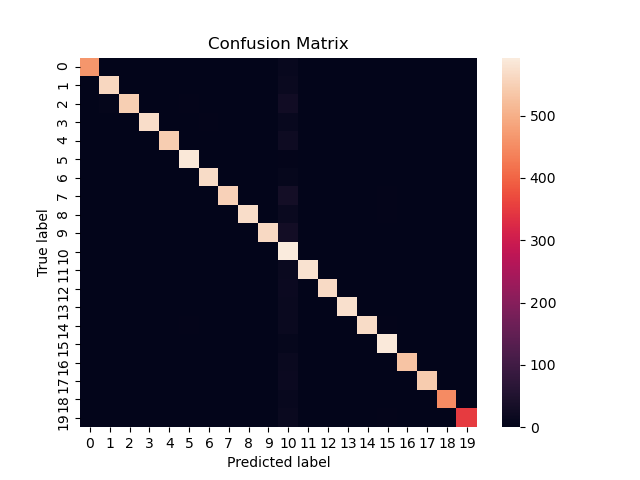

In [42]:
report_clf_evals(basic_clf,X_train,y_train)

  Accuracy: 0.6111
  Precision: 0.6806
  Recall: 0.5953
  F1: 0.5801


<IPython.core.display.Javascript object>


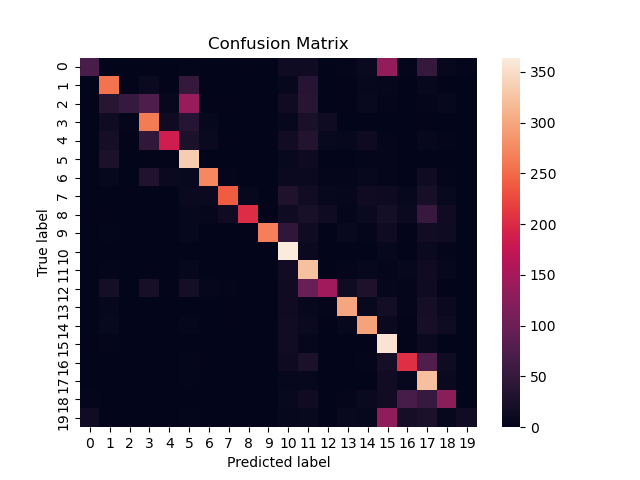

rec.sport.hockey sci.crypt


In [43]:
##What are labels 10 and 11? 
report_clf_evals(basic_clf,X_test,y_test)
print(target_names_dict[10],target_names_dict[11])
